In [34]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns

from allen_v1dd.client import OPhysClient
from allen_v1dd.stimulus_analysis import LocallySparseNoise
from allen_v1dd.stimulus_analysis import analysis_tools as at
at.set_stylesheet()

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
client = OPhysClient("/Users/chase/Desktop/test_v1dd_data/")

In [3]:
metrics_rows = []

for vol in tqdm([1, 2, 3, 4, 5, 6]):
    session = client.load_ophys_session(mouse=409828, column=1, volume=vol)
    running_speed = session.get_running_speed()
    running_timestamps = running_speed.time.values
    running_speed = running_speed.values

    for plane in tqdm(session.get_planes(), leave=False, desc=f"Volume {vol}"):
        # Syncing running speed to dF/F timestamps because running speed is sampled at higher res
        dff_xr = session.get_traces(plane, "dff")
        start_time = max(dff_xr.time.values[0], running_timestamps[0])
        end_time = min(dff_xr.time.values[-1], running_timestamps[-1])
        dff_xr = dff_xr.sel(time=slice(start_time, end_time))
        dff = dff_xr.values
        dff_timestamps = dff_xr.time.values
        run_synced = np.empty(len(dff_timestamps), dtype=float)
        mean_time_window = np.mean(np.diff(dff_timestamps)) / 2

        for i, time in enumerate(dff_timestamps):
            # run_synced[i] = running_speed.sel(time=time, method="nearest").item()
            run_synced[i] = running_speed[(time-mean_time_window <= running_timestamps) & (running_timestamps <= time+mean_time_window)].mean()
        
        corr_mat = np.corrcoef(np.vstack((dff, run_synced))) # corr_mat[i, -1] is the running correlation of ROI i
        roi_run_corr = corr_mat[:-1, -1]
        
        for roi in session.get_rois(plane):
            metrics = {}
            metrics_rows.append(metrics)

            metrics["volume"] = vol
            metrics["roi"] = f"{session.get_session_id()}_{plane}_{roi}"
            metrics["is_valid"] = session.is_roi_valid(plane, roi)

            if not metrics["is_valid"]:
                continue

            metrics["run_corr"] = roi_run_corr[roi]
            
            # Save ROI centroid
            image_mask = session.get_roi_image_mask(plane, roi)
            y, x = np.mean(np.where(image_mask), axis=1)
            metrics["roi_centroid_x_px"] = x
            metrics["roi_centroid_y_px"] = y
            metrics["depth_microns"] = session.get_plane_depth(plane)

metrics = pd.DataFrame(metrics_rows)
metrics.set_index("roi", inplace=True)

metrics = metrics[metrics.is_valid]
metrics

  0%|          | 0/6 [00:00<?, ?it/s]

Volume 1:   0%|          | 0/6 [00:00<?, ?it/s]

Volume 2:   0%|          | 0/6 [00:00<?, ?it/s]

Volume 3:   0%|          | 0/6 [00:00<?, ?it/s]

Volume 4:   0%|          | 0/6 [00:00<?, ?it/s]

Volume 5:   0%|          | 0/6 [00:00<?, ?it/s]

Volume 6:   0%|          | 0/1 [00:00<?, ?it/s]

,volume,is_valid,run_corr,roi_centroid_x_px,roi_centroid_y_px,depth_microns
roi,,,,,,
M409828_11_1_89,1,True,0.011718,496.677885,257.625000,50.0
M409828_11_2_0,1,True,-0.027196,91.182156,215.000000,66.0
M409828_11_2_1,1,True,0.053720,140.030000,174.300000,66.0
M409828_11_2_2,1,True,-0.028937,182.218254,101.853175,66.0
M409828_11_2_4,1,True,0.007350,496.240113,262.016949,66.0
...,...,...,...,...,...,...
M409828_16_1_178,6,True,0.115009,295.095638,128.498322,500.0
M409828_16_1_182,6,True,-0.011669,357.235908,257.703549,500.0
M409828_16_1_185,6,True,0.128738,31.436416,324.956647,500.0


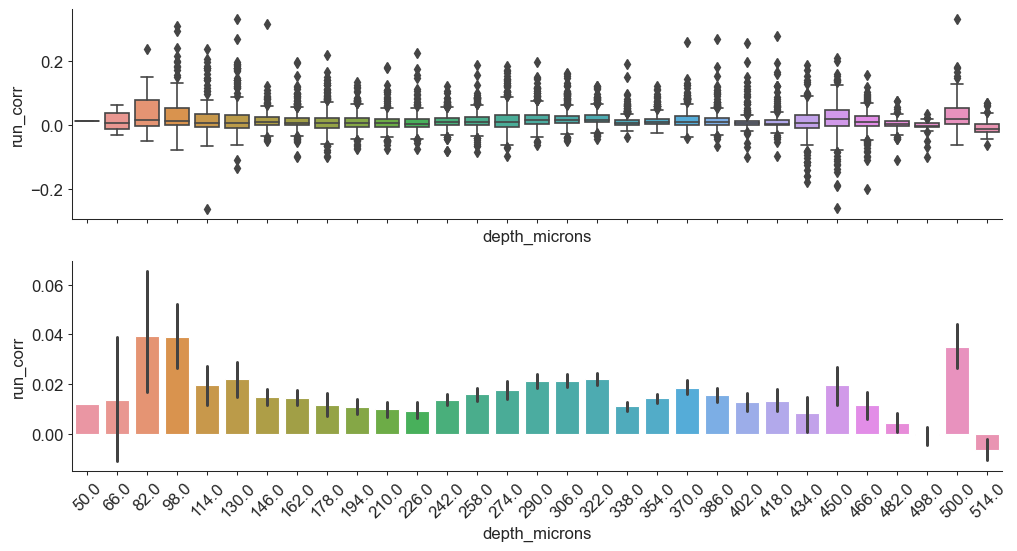

In [4]:
fig, axs = plt.subplots(figsize=(12, 6), nrows=2, sharex=True)
sns.boxplot(data=metrics, x="depth_microns", y="run_corr", ax=axs[0])
sns.barplot(data=metrics, x="depth_microns", y="run_corr", ax=axs[1])
plt.setp(axs[1].get_xticklabels(), rotation=45)
None

# Test spatial patchiness (doesn't appear to be)

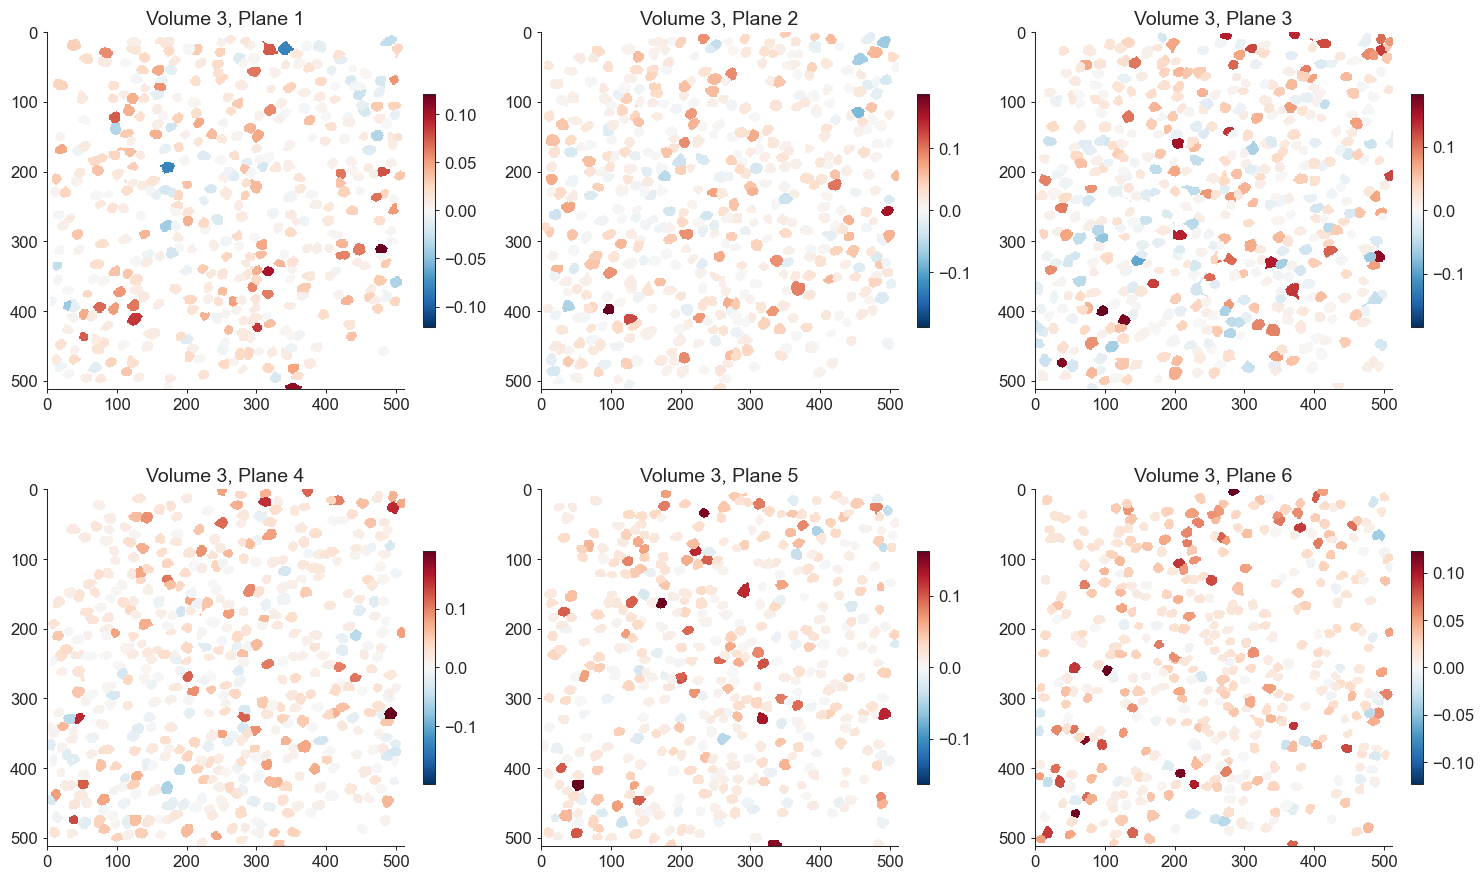

In [48]:
volume = 3
session = client.load_ophys_session(mouse=409828, column=1, volume=volume)
all_roi_mask_by_plane = {}

for roi_idx in metrics.index:
    sid, plane, roi = roi_idx.rsplit("_", 2)
    if sid != session.get_session_id(): continue
    plane = int(plane)
    roi = int(roi)
    roi_mask = session.get_roi_image_mask(plane, roi)
    run_corr = metrics.at[roi_idx, "run_corr"]

    if plane not in all_roi_mask_by_plane:
        all_roi_mask_by_plane[plane] = np.full_like(roi_mask, np.nan, dtype=float)
    
    all_roi_mask_by_plane[plane][roi_mask] = run_corr

all_planes = sorted(all_roi_mask_by_plane.keys())
fig, axs = plt.subplots(figsize=(15, 10), nrows=2, ncols=3)

for i, ax in enumerate(axs.flat):
    if i >= len(all_planes):
        ax.axis("off")
        continue

    plane = all_planes[i]
    all_roi_mask = all_roi_mask_by_plane[plane]
    vmax = np.nanmax(np.abs(all_roi_mask))
    im = ax.imshow(all_roi_mask, cmap="RdBu_r", interpolation="nearest", vmin=-vmax, vmax=vmax)
    plt.colorbar(im, fraction=0.03)

    ax.set_title(f"Volume {session.get_volume_id()}, Plane {plane}")

    fig.tight_layout()

  0%|          | 0/2708 [00:00<?, ?it/s]

r_test: PearsonRResult(statistic=0.026656273160753263, pvalue=0.0)
ks_near_far: KstestResult(statistic=0.0161123269330411, pvalue=1.2549208132245926e-24, statistic_location=0.030193003798443228, statistic_sign=1)


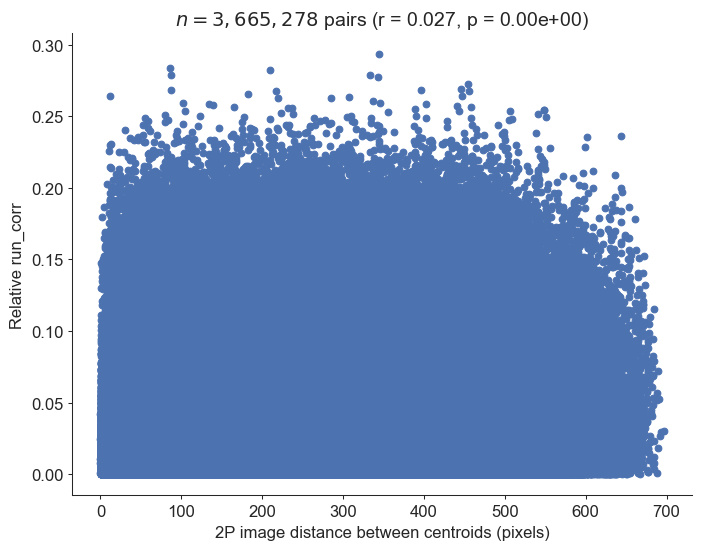

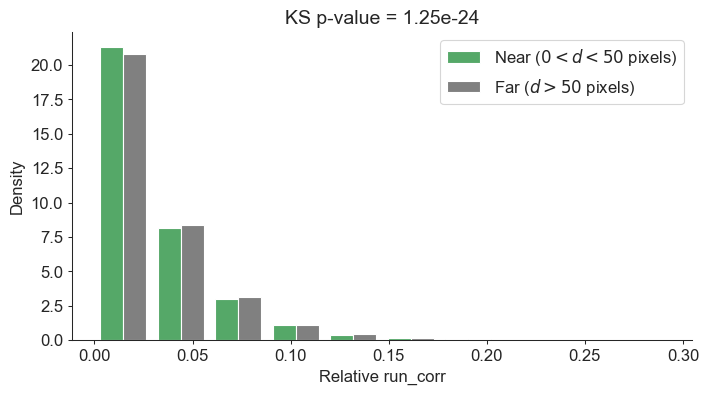

In [43]:
xyz = np.vstack((metrics.roi_centroid_x_px, metrics.depth_microns, metrics.roi_centroid_y_px)).T
metric_values = metrics.run_corr.values

mask = metrics.volume == 3
xyz = xyz[mask]
metric_values = metric_values[mask]

xy = xyz[:, ::2]

pairwise_dist = scipy.spatial.distance_matrix(xy, xy)
# pairwise_dist = scipy.spatial.distance_matrix(xyz, xyz)
pairwise_dist[np.tril_indices_from(pairwise_dist)] = np.nan
pairwise_dist[pairwise_dist > 1000] = np.nan
pairwise_dist = np.ma.masked_invalid(pairwise_dist)


# Plot delta metric vs. distance
pair_distances, delta_metrics = [], []
for i in tqdm(range(pairwise_dist.shape[0])):
    for j in range(i+1, pairwise_dist.shape[1]):
        if pairwise_dist.mask[i, j]:
            # This is an invalid pair
            continue
        
        d = pairwise_dist[i, j]
        delta_metric = abs(metric_values[i] - metric_values[j])
        pair_distances.append(d)
        delta_metrics.append(delta_metric)

pair_distances = np.array(pair_distances)
delta_metrics = np.array(delta_metrics)
r_test = scipy.stats.pearsonr(pair_distances, delta_metrics)

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(pair_distances, delta_metrics, color="b")
# at.density_scatter(pair_distances, delta_metrics, ax=ax, alpha=0.25) # Slow for large numbers of ROIs
ax.set_xlabel("2P image distance between centroids (pixels)")
ax.set_ylabel("Relative run_corr")
ax.set_title(f"$n = {len(pair_distances):,}$ pairs (r = {r_test.statistic:.3f}, p = {r_test.pvalue:.2e})")
print("r_test:", r_test)


# Plot number pairs vs. delta metric bin
fig, ax = plt.subplots(figsize=(8, 4))
# bins = np.arange(0, 2, 0.2) # for SSI
bins = None
near_distance = 50
near_distribution = delta_metrics[pair_distances < near_distance]
far_distribution = delta_metrics[(pair_distances > near_distance) & (pair_distances < 600)]

ks_near_far = scipy.stats.ks_2samp(near_distribution, far_distribution)

# sns.histplot(near_distribution, bins=bins, ax=ax_near, color="b")
ax.hist([near_distribution, far_distribution], bins=bins, density=True, color=("g", "gray"), label=(f"Near ($0 < d < {near_distance}$ pixels)", f"Far ($d > {near_distance}$ pixels)"))
ax.set_title(f"KS p-value = {ks_near_far.pvalue:.2e}")
ax.set_xlabel("Relative run_corr")
ax.set_ylabel("Density")
# ax.set_xticks(bins)
ax.legend(bbox_to_anchor=(1, 1), bbox_transform=ax.transAxes)

print("ks_near_far:", ks_near_far)


## Since there is no difference in bin density, we can conclude there is no tendency for ROIs closer together to have similar running correlations